In [1]:
import xarray as xr
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import genextreme as gev
from scipy.stats import genextreme
from itertools import groupby
from synthesis_functions import linreg, get_confidence_levels, get_confidence_levels_pr, get_confidence_levels_rc, getsynchi2, getsynmean,synthesis, plot_synthesis

import warnings 
warnings.filterwarnings('ignore')


In [2]:
#observational data extraction, copied and shuffled arround from attribution_serbia.ipynb

#defining the time period of interest, months of the season of interest and the index definition (lenght of averaging days for tmax), used both here and in the model section
date_st = "1951-01-01"
date_en = "2024-12-31"
event_date_st = "2024-06-01" ##FOLLOW THE FORMAT FOR CORRECT DEFINITIONS OF START AND END MONTHS AND DATES
event_date_en = "2024-08-31"
mon_st = int(event_date_st[5:7])
day_st = int(event_date_st[8:10])
mon_en = int(event_date_en[5:7])
day_en = int(event_date_en[8:10])
season = 'JJA24'
obl = "srb"
ravg=3 #10 #no of days for calculating running average

ds_temp = xr.open_dataset("../serbia/indata/tx_ksrs_19502025.nc") #read observation input file

#gmst data
ds_gmst = xr.open_dataset("../indata/tas_mean_mon_1950-2024.nc") #monthly mean GMST anomaly 1880-2024
gmst = ds_gmst['tas_mean'].groupby('time.year').mean('time').sel(year=slice(date_st[:4],date_en[:4])) # Calculate yearly mean from monthly values; 1950-2024 or 1950-2023 if we want to exclude the observed event!
gmst_4yr = gmst.rolling(year=4, min_periods=1).mean()  #4-year rolling avg


t2m = ds_temp['t2m'].mean(dim=["latitude", "longitude"]).sel(valid_time=slice(date_st, date_en)) - 273.16 #exclude the observed event! change K to C!

#calculate the running mean
center = True
t_ravg = t2m.rolling(valid_time=ravg, center=center).mean()

#t_ravg_ses = t_ravg.sel(valid_time=t_ravg['valid_time'].dt.season == season) # !Attention! to how dimension 'time' is named in the file; era5land: 'valid_time'

#'''
#-------------------------------------------------------------------------------------------
#choose single month or particular period during the year:
t_ravg_ses = t_ravg.sel(
    valid_time=( 
                ((t_ravg['valid_time'].dt.month == mon_st) & (t_ravg['valid_time'].dt.day >= day_st)) |
                (t_ravg['valid_time'].dt.month > mon_st) & (t_ravg['valid_time'].dt.month < mon_en)) |
                ((t_ravg['valid_time'].dt.month == mon_en) & (t_ravg['valid_time'].dt.day <= day_en))
)
#-------------------------------------------------------------------------------------------
#'''  

#calculating the index value for event of interest, as we haven't select it before
t_event = ds_temp['t2m'].mean(dim=["latitude", "longitude"]).sel(valid_time=slice(event_date_st, event_date_en)).rolling(valid_time=ravg, center=True).mean().max() - 273.16

#maximum of t_ravg -> t_ravg per year (for JJA)
t_ravgX_ses = t_ravg_ses.groupby("valid_time.year").max()

years = t_ravgX_ses['year'].squeeze().values # extract years from input file
temps = t_ravgX_ses.squeeze().values

alpha, b, temps_pred = linreg(gmst_4yr, temps)

In [4]:
#calculation of observed mean and standard deviation values:

#Fitting the data to the distribution that represents it the best
params = stats.genextreme.fit(temps)
c, mu0, sigma = params

#Taking the trend coeffitient between μ and GMST' and adding it to μ0 values 
mu = mu0 + alpha * gmst_4yr
print(mu)

pr, cf_low, cf_up = get_confidence_levels_pr(t_event, temps,  mu[-1].to_numpy(), mu[0].to_numpy() , mu0 )

obs_pr = pd.DataFrame(columns = ['est','lower','upper', 'model'])
new_row = {'est' : pr, 'lower' : cf_low, 'upper': cf_up, 'model' : 'ERA5'}
obs_pr.loc[len(obs_pr)] = new_row
obs_pr = obs_pr.set_index('model')

<xarray.DataArray 'tas_mean' (year: 74)> Size: 592B
array([31.26969495, 31.36093184, 31.44085399, 31.36491477, 31.28373133,
       31.11766277, 31.05030663, 31.10940586, 31.19842953, 31.28649973,
       31.29564336, 31.26797115, 31.27464573, 31.16111795, 31.0511565 ,
       31.0005615 , 30.95242676, 31.03424104, 31.13741326, 31.17547421,
       31.12279538, 31.16742866, 31.21592576, 31.16377597, 31.22050042,
       31.14773035, 31.17941425, 31.28541767, 31.40562969, 31.65123173,
       31.73883537, 31.75613406, 31.83540694, 31.74711464, 31.62769567,
       31.66431676, 31.6757747 , 31.81539229, 31.89261934, 32.05056408,
       32.10772696, 32.01396323, 32.00588811, 31.93014451, 31.95278401,
       32.04329082, 32.1962902 , 32.40127724, 32.37004479, 32.40247821,
       32.44241038, 32.42221218, 32.55320019, 32.63446114, 32.70456989,
       32.72191263, 32.75025324, 32.74922716, 32.7432164 , 32.80750366,
       32.77530385, 32.8420587 , 32.85803454, 32.8535628 , 33.02493593,
       33.23

In [6]:
#model data extraction
models_pr = pd.DataFrame(columns = ['est','lower','upper', 'model'])

model_files = [
#filtered out    "mod_tasmax_vre_1951-2025_na_rcp45_na_d_gcm-ICHEC-EC-EARTH-rcm-CLMcom-CCLM4-8-17_srb.nc",
    "mod_tasmax_vre_1951-2025_na_rcp45_na_d_gcm-ICHEC-EC-EARTH-rcm-DMI-HIRHAM5_srb.nc",
    "mod_tasmax_vre_1951-2025_na_rcp45_na_d_gcm-ICHEC-EC-EARTH-rcm-KNMI-RACMO22E_srb.nc",
    "mod_tasmax_vre_1951-2025_na_rcp45_na_d_gcm-MOHC-HadGEM2-ES-rcm-CLMcom-CCLM4-8-17_srb.nc",
    "mod_tasmax_vre_1951-2025_na_rcp45_na_d_gcm-MOHC-HadGEM2-ES-rcm-KNMI-RACMO22E_srb.nc", #these two models do not have a monotonous time index
    "mod_tasmax_vre_1951-2025_na_rcp45_na_d_gcm-MPI-M-MPI-ESM-LR-rcm-CLMcom-CCLM4-8-17_srb.nc",
    "mod_tasmax_vre_1951-2025_na_rcp45_na_d_gcm-MPI-M-MPI-ESM-LR-rcm-MPI-CSC-REMO20091_srb.nc",
    "mod_tasmax_vre_1951-2025_na_rcp45_na_d_gcm-MPI-M-MPI-ESM-LR-rcm-MPI-CSC-REMO20092_srb.nc",
]

model_results = {}

for file in model_files:
    model_name = file.split("gcm-")[-1].replace("_srb.nc", "")
    print(f"\nProcessing model: {model_name}")
    # # TG3x - 3-day running mean of daily mean temperature / TX3x 3-day running mean of daily maximum temperature
    # https://doi.org/10.1029/2021EF002271 

    #### Calculation of event definition #####

    ds_temp = xr.open_dataset(f"../model_evaluation/output_srb/rcp45/{file}")
    
    if (model_name == "MOHC-HadGEM2-ES-rcm-CLMcom-CCLM4-8-17" or model_name == "MOHC-HadGEM2-ES-rcm-KNMI-RACMO22E"):
        ds_temp = ds_temp.sortby("time")
        ti = ds_temp["time"].to_index()
        dupe_mask = ti.duplicated(keep="first")  # True where it's a duplicate
        ds_temp = ds_temp.isel(time=~dupe_mask)
        t2m = (ds_temp["tasmax"]
            .mean(dim=["latitude", "longitude"])
            .sel(time=slice(date_st, date_en))
        )
    else:
        t2m = ds_temp['tasmax'].mean(dim=["latitude", "longitude"]).sel(time=slice(date_st, date_en)) #in celsius already 
    
    #calculate the running mean
    center = True
    t_ravg = t2m.rolling(time=ravg, center=center).mean()
    
    #choose season
     #t_ravg_ses = t_ravg.sel(valid_time=t_ravg['valid_time'].dt.season == season) # !Attention! to how dimension 'time' is named in the file; era5land: 'valid_time'
    #'''
    #-------------------------------------------------------------------------------------------
    #choose single month or particular period during the year:
    t_ravg_ses = t_ravg.sel(
    time=( 
                ((t_ravg['time'].dt.month == mon_st) & (t_ravg['time'].dt.day >= day_st)) |
                (t_ravg['time'].dt.month > mon_st) & (t_ravg['time'].dt.month < mon_en)) |
                ((t_ravg['time'].dt.month == mon_en) & (t_ravg['time'].dt.day <= day_en))
)
    #-------------------------------------------------------------------------------------------
    #'''  

    #maximum of t_ravg -> t_ravg per year (for JJA)
    t_ravgX_ses = t_ravg_ses.groupby("time.year").max()

    years = t_ravgX_ses['year'].squeeze().values # extract years from input file
    temps = t_ravgX_ses.squeeze().values #if in Kelvin convert to Celsius
    alpha, b, tX_pred = linreg(gmst_4yr,temps)

    params = stats.genextreme.fit(temps)
    c, mu0, sigma = params
    mu = mu0 + alpha * gmst_4yr
    
    pr, cf_low, cf_up = get_confidence_levels_pr(t_event, temps,  mu[-1].to_numpy(), mu[0].to_numpy() , mu0 )
    new_row = {'est' : pr, 'lower' : cf_low, 'upper': cf_up, 'model' : model_name}
    models_pr.loc[len(models_pr)] = new_row

models_pr = models_pr.set_index('model')


Processing model: ICHEC-EC-EARTH-rcm-DMI-HIRHAM5

Processing model: ICHEC-EC-EARTH-rcm-KNMI-RACMO22E

Processing model: MOHC-HadGEM2-ES-rcm-CLMcom-CCLM4-8-17

Processing model: MOHC-HadGEM2-ES-rcm-KNMI-RACMO22E

Processing model: MPI-M-MPI-ESM-LR-rcm-CLMcom-CCLM4-8-17

Processing model: MPI-M-MPI-ESM-LR-rcm-MPI-CSC-REMO20091

Processing model: MPI-M-MPI-ESM-LR-rcm-MPI-CSC-REMO20092


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Synthesis plot JJA24'}, xlabel='Probability ratio'>)

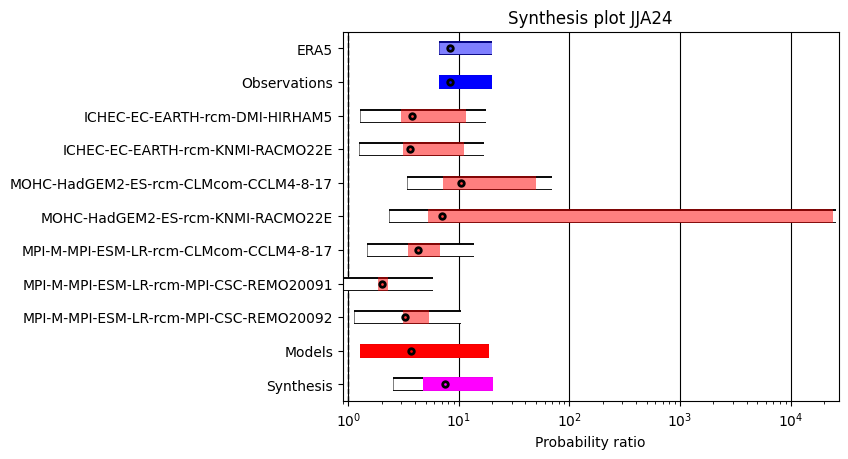

In [7]:
res_pr = synthesis(obs_pr, models_pr, synth_type = "PR")
plot_synthesis(res_pr, season = season)